In [ ]:
import os
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr
from IPython.display import clear_output

In [ ]:
NUM_EPISODES = 2000

IDX_ACTION_UP = 0
IDX_ACTION_DOWN = 1
IDX_ACTION_RIGHT = 2
IDX_ACTION_LEFT = 3

STR_ACTION_UP = 'U'
STR_ACTION_DOWN = 'D'
STR_ACTION_RIGHT = 'R'
STR_ACTION_LEFT = 'L'

POINT_WALL = [[1, 1], [1, 3], [2, 3], [3, 0]]
POINT_GOAL = [[3, 3]]


In [ ]:
def rargmax(vector):
    # np,amax = array의 최댓값 반환
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0] 
    # 0이 아닌값 중에 m과 같은 값이 있으면
    # pr.choice(indices)
    # indices 중 random으로 choice
    return pr.choice(indices)


In [ ]:
def get_cnt_tracking(log_action):
    tracking = []
    for act_ in log_action:
        buf_tracking = [[None for _ in range(4)] for _ in range(4)]

        row = 0
        col = 0
        cnt = 0
        while cnt < len(act_):
            row = 0 if row < 0 else 3 if row >= 4 else row
            col = 0 if col < 0 else 3 if col >= 4 else col

            if buf_tracking[row][col] is None:
                buf_tracking[row][col] = str(cnt)
            else:
                buf_tracking[row][col] = buf_tracking[row][col] + ', ' + str(cnt)

            if act_[cnt] == IDX_ACTION_UP:
                row -= 1
            elif act_[cnt] == IDX_ACTION_DOWN:
                row += 1
            elif act_[cnt] == IDX_ACTION_RIGHT:
                col += 1
            elif act_[cnt] == IDX_ACTION_LEFT:
                col -= 1
            else:
                pass
            cnt += 1
        tracking.append(buf_tracking)
    return tracking

def get_point_tracking(log_action):
    tracking = []
    for act_ in log_action:
        row = 0
        col = 0
        cnt = 0
        buf_tracking = [[row, col]]
        while cnt < len(act_):
            if act_[cnt] == IDX_ACTION_UP:
                row -= 1
            elif act_[cnt] == IDX_ACTION_DOWN:
                row += 1
            elif act_[cnt] == IDX_ACTION_RIGHT:
                col += 1
            elif act_[cnt] == IDX_ACTION_LEFT:
                col -= 1
            else:
                pass

            row = 0 if row < 0 else 3 if row >= 4 else row
            col = 0 if col < 0 else 3 if col >= 4 else col
            buf_tracking.append([row, col])
            cnt += 1
        tracking.append(buf_tracking)
    return tracking


In [ ]:
def print_result_q(q_value, log_reword, num_episodes):
    print('Success rate : ' + str(sum(log_reword) / num_episodes))
    print('Final Q-Table')
    # print('LEFT DOWN RIGHT UP')
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(4):
            txt += ','.join([str(int(e)) for e in q_value[cnt]])
            txt += ' | '
            cnt += 1
        print(txt)

def print_str_direct(q_value):
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(4):
            q = ''.join([str(int(e)) for e in q_value[cnt]])
            if q == '1000':
                txt += STR_ACTION_UP
            elif q == '0100':
                txt += STR_ACTION_DOWN
            elif q == '0010':
                txt += STR_ACTION_RIGHT
            elif q == '0001':
                txt += STR_ACTION_LEFT
            else:
                txt += ' '
            txt += ' | '
            cnt += 1
        print(txt)

def print_tracking_graphic(tracking, wall, goal):
    for idx, trk in enumerate(tracking):
        print(idx)
        map_ = [['  ' for _ in range(4)] for _ in range(4)]
        for p_ in wall:
            map_[p_[0]][p_[1]] = '■'
        for p_ in goal:
            map_[p_[0]][p_[1]] = 'G'
        map_[trk[0]][trk[1]] = '☆'
        for row in range(4):
            print(map_[row])
        time.sleep(1)
        if idx < len(tracking)-1:
            clear_output(wait=False)

def print_p_value_graphic(tracking, p_value, wall, goal):
    map_ = [['  ' for _ in range(4)] for _ in range(4)]
    for idx, trk in enumerate(tracking):
        print(idx)
        for p_ in wall:
            map_[p_[0]][p_[1]] = '■'
        for p_ in goal:
            map_[p_[0]][p_[1]] = 'G'

        p_ = ''.join([str(int(e)) for e in p_value[idx]])
        if int(p_) != 0:
            map_[trk[0]][trk[1]] = '1'
        else:
            map_[trk[0]][trk[1]] = '0'        
        for row in range(4):
            print(map_[row])
        time.sleep(1)
        if idx < len(tracking)-1:
            clear_output(wait=False)

def print_p_value(tracking, p_value, wall, goal):
    map_ = [['  ' for _ in range(4)] for _ in range(4)]
    for idx, trk in enumerate(tracking):
        for p_ in wall:
            map_[p_[0]][p_[1]] = '■'
        for p_ in goal:
            map_[p_[0]][p_[1]] = 'G'

        p_ = ''.join([str(int(e)) for e in p_value[idx]])
        if int(p_) != 0:
            map_[trk[0]][trk[1]] = '1'
        else:
            map_[trk[0]][trk[1]] = '0'        
    for row in range(4):
        print(map_[row])


In [ ]:
def run_q_learning(env, num_episodes):
    # Q-value table 생성
    q_value = np.zeros([env.observation_space.n, env.action_space.n])

    # reword 저장
    log_action = []
    log_q_value = []
    log_reword = []
    for i in range(num_episodes):
        done = False
        # 해당 learning reword
        rAll = 0
        # 초기 state로 설정
        state = env.reset()

        buf_q = []
        buf_act = []
        while not done:
            action = rargmax(q_value[state, :])

            # 밑줄은 step의 매개변수 4개중 하나로 값없음
            # done : learning 종료 (목적지 도착)
            new_state, reward, done,_ = env.step(action)

            q_value[state, action] = reward + np.max(q_value[new_state,:])

            buf_q.append(list(q_value[state]))
            if done:
                buf_q.append(list(q_value[new_state]))
            buf_act.append(action)
            rAll += reward
            state = new_state
        log_action.append(buf_act)
        log_q_value.append(buf_q)
        log_reword.append(rAll)
    return q_value, log_action, log_q_value, log_reword


---

In [ ]:
# entry_point : gym.envs 환경 불러오기
register(
    id='LakeEnv-',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name':'4x4', 'is_slippery':False}
)
env = gym.make('LakeEnv-')

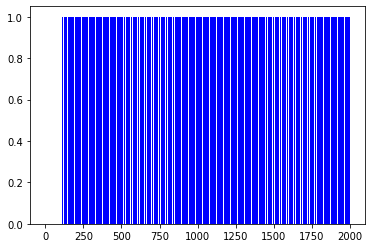

In [ ]:
q_value, log_action, log_q_value, log_reword = run_q_learning(env, NUM_EPISODES)
plt.bar(range(len(log_reword)), log_reword, color='blue')
plt.show()


In [ ]:
print_result_q(q_value, log_reword, NUM_EPISODES)


Success rate : 0.9395
Final Q-Table
0,0,1,0 | 0,0,1,0 | 0,1,0,0 | 0,0,0,0 | 
0,1,0,0 | 0,0,0,0 | 0,1,0,0 | 0,0,0,0 | 
0,0,1,0 | 0,0,1,0 | 0,1,0,0 | 0,0,0,0 | 
0,0,0,0 | 0,0,0,0 | 0,0,1,0 | 0,0,0,0 | 


In [ ]:
print_str_direct(q_value)


R | R | D |   | 
D |   | D |   | 
R | R | D |   | 
  |   | R |   | 


In [ ]:
tracking_map = get_cnt_tracking(log_action)


In [ ]:
tracking_map[83]

[['0, 1, 6, 8', '2, 3, 4, 5, 7, 9', None, None],
 [None, '10', None, None],
 [None, '11', None, None],
 ['13, 14, 15', '12', None, None]]

In [ ]:
tracking_point = get_point_tracking(log_action)


In [ ]:
idx = 83
print_tracking_graphic(tracking_point[idx], POINT_WALL, POINT_GOAL)


16
['  ', '  ', '  ', '  ']
['  ', '■', '  ', '■']
['  ', '  ', '  ', '■']
['■', '☆', '  ', 'G']


In [ ]:
print_p_value_graphic(tracking_point[idx], log_q_value[idx], POINT_WALL, POINT_GOAL)

['0', '  ', '  ', '  ']
['0', '0', '  ', '■']
['  ', '  ', '  ', '■']
['■', '  ', '  ', 'G']


In [ ]:
log_reword[83]

1.0

In [ ]:
# num_simul = NUM_EPISODES
num_simul = 83
for idx in range(40, num_simul):
    print(idx)
    print_p_value(tracking_point[idx], log_q_value[idx], POINT_WALL, POINT_GOAL)
    time.sleep(1)
    if idx < num_simul-1:
        clear_output(wait=False)

In [ ]:
log_action[83]

[0, 2, 0, 0, 0, 3, 2, 3, 2, 1, 1, 1, 3, 1, 1, 2]

In [ ]:
tracking_point[83]

[[0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [3, 0],
 [3, 0],
 [3, 0],
 [3, 1]]

In [ ]:
log_q_value[83]

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

In [ ]:
tracking_point_reword = []
q_value_reword = []
for idx in range(NUM_EPISODES):
    if log_reword[idx] == 1:
        print(idx)
        tracking_point_reword.append(tracking_point[idx])
        q_value_reword.append(log_q_value[idx])


In [ ]:
for idx in range(3):
    print_p_value(tracking_point_reword[idx], q_value_reword[idx], POINT_WALL, POINT_GOAL)
    time.sleep(1)
    if idx < 3-1:
        clear_output(wait=False)

['0', '  ', '  ', '  ']
['0', '■', '0', '■']
['  ', '  ', '1', '■']
['■', '  ', '1', '0']


In [ ]:
idx = 83
print_p_value(tracking_point_reword[idx], q_value_reword[idx], POINT_WALL, POINT_GOAL)


['1', '1', '1', '  ']
['  ', '■', '1', '■']
['  ', '  ', '1', '■']
['■', '  ', '1', '0']


In [ ]:
tracking_point_reword[0]

[[0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [3, 0],
 [3, 0],
 [3, 0],
 [3, 1]]

In [ ]:
q_value_reword[0]

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

In [ ]:
idx = 1
print_p_value(tracking_point_reword[idx], q_value_reword[idx], POINT_WALL, POINT_GOAL)


['0', '0', '  ', '  ']
['0', '■', '  ', '■']
['1', '  ', '  ', '■']
['■', '0', '  ', 'G']


In [ ]:
idx = 2
print_p_value(tracking_point_reword[idx], q_value_reword[idx], POINT_WALL, POINT_GOAL)


['0', '  ', '  ', '  ']
['0', '■', '0', '■']
['  ', '  ', '1', '■']
['■', '  ', '1', '0']
